In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:

df = pd.read_csv('Telco-Customer-Churn.csv')


print("First 5 rows of the dataset:")
display(df.head())


print("\\nDataset Info:")
df.info()


print("\\nSummary Statistics:")
display(df.describe())

First 5 rows of the dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


\nDataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


 Convert 'TotalCharges' to a numeric type, coercing errors to NaN

In [74]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')



In [75]:
print(f"Number of missing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")

df.dropna(subset=['TotalCharges'], inplace=True)



Number of missing values in TotalCharges: 11


Convert the target variable 'Churn' to binary format (0 or 1)

In [76]:

df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


In [77]:
X = df.drop('Churn', axis=1)
y = df['Churn']

Identify categorical and numerical features

In [78]:

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

Create preprocessing pipelines for numerical and categorical features
   

In [79]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

Create a preprocessor object using ColumnTransformer to apply different transformations to different columns

In [80]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
         ])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the logistic regression model pipeline

In [82]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='liblinear'))])

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])





In [85]:
rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)

In [86]:
print("--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

--- Random Forest Evaluation ---
Accuracy: 0.7925
\nClassification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1033
           1       0.66      0.45      0.54       374

    accuracy                           0.79      1407
   macro avg       0.74      0.68      0.70      1407
weighted avg       0.78      0.79      0.78      1407



Get feature importances from the trained Random Forest model

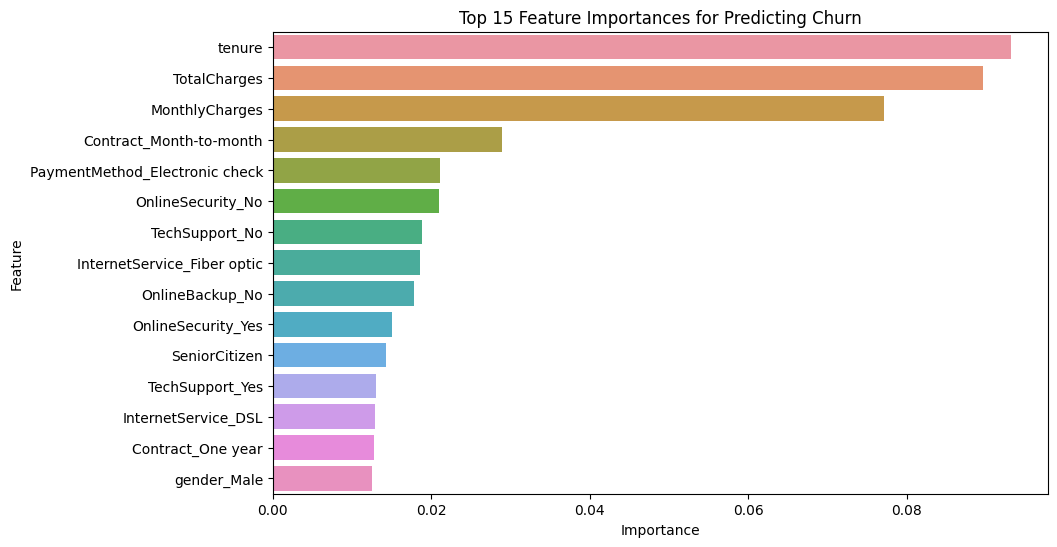

In [87]:

importances = rf_model.named_steps['classifier'].feature_importances_


preprocessor = rf_model.named_steps['preprocessor']
feature_names = numerical_features.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()


feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances for Predicting Churn')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

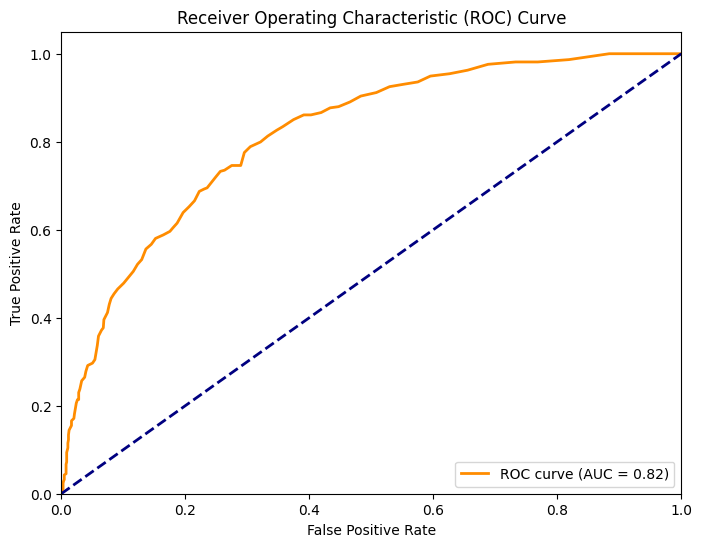

In [88]:
from sklearn.metrics import roc_curve, auc


y_pred_proba = rf_model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

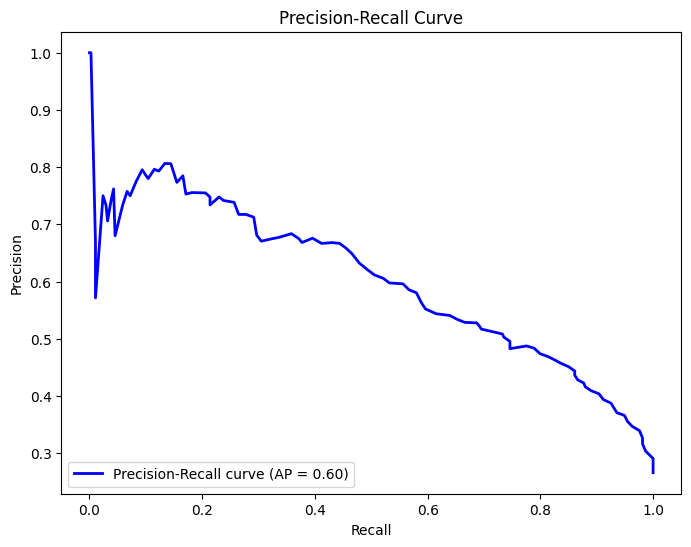

In [89]:
from sklearn.metrics import precision_recall_curve, average_precision_score


precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

 Create a DataFrame with actual and predicted probabilities

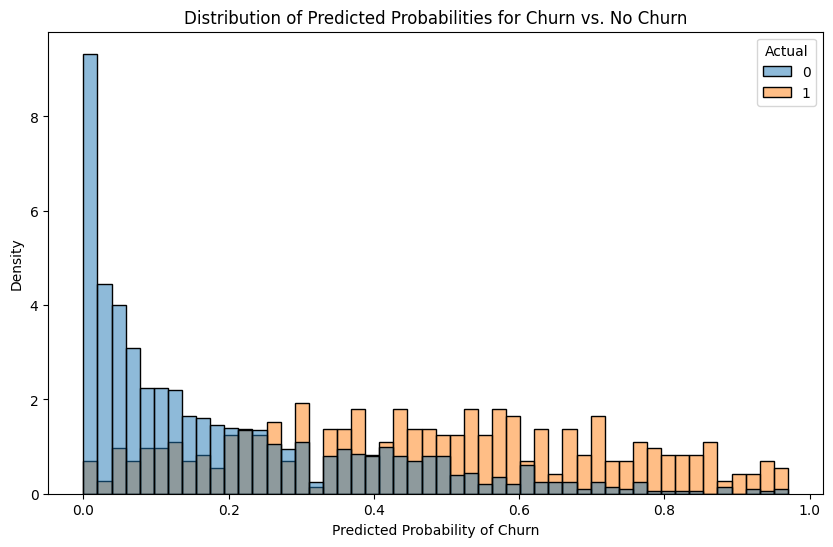

In [90]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted_Probability': y_pred_proba})

plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='Predicted_Probability', hue='Actual', bins=50, stat='density', common_norm=False)
plt.title('Distribution of Predicted Probabilities for Churn vs. No Churn')
plt.xlabel('Predicted Probability of Churn')
plt.ylabel('Density')
plt.show()

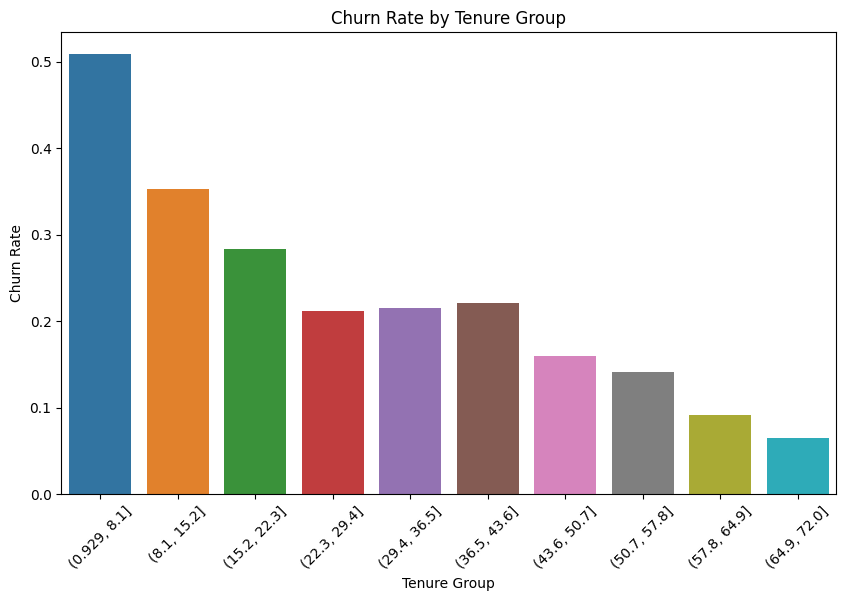

In [91]:
df['tenure_group'] = pd.cut(df['tenure'], bins=10)
churn_by_tenure = df.groupby('tenure_group')['Churn'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='tenure_group', y='Churn', data=churn_by_tenure)
plt.title('Churn Rate by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()